# stock prediction
reference: https://towardsdatascience.com/predicting-apple-stock-in-times-of-coronavirus-ca434bd2f788

In [21]:
import json
import OpenBlender
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 50)
pd.set_option('max_colwidth',200)

In [53]:
# stock_data_path = "../data/stock_data/apple_stock.json"
vectorized_news_data_path = "../data/stock_data/vectorized_news.json"

In [54]:
# read stock data
# stock_data = pd.read_json(stock_data_path, convert_dates=False, convert_axes=False).sort_values("timestamp")
# stock_data.reset_index(drop=True, inplace=True)

In [56]:
# stock_data["timestamp"] = stock_data["timestamp"].apply(lambda x: pd.to_datetime(int(x), unit='s'))

In [58]:
# stock_data.drop_duplicates(subset=["timestamp"], keep='first')

,volume,timestamp,price,high,low,open,change
0,28.78M,2017-01-03 16:00:00,116.15,116.33,114.76,115.80,0.28%
1,21.12M,2017-01-04 16:00:00,116.02,116.51,115.75,115.85,-0.11%
2,22.19M,2017-01-05 16:00:00,116.61,116.86,115.81,115.92,0.51%
3,31.75M,2017-01-06 16:00:00,117.91,118.16,116.47,116.78,1.11%
4,33.56M,2017-01-09 16:00:00,118.99,119.43,117.94,117.95,0.92%
...,...,...,...,...,...,...,...
781,71.88M,2020-03-25 22:05:39,246.88,246.88,234.42,237.00,10.03%
782,75.90M,2020-03-26 04:05:46,245.52,257.94,244.33,250.80,-0.55%
783,75.90M,2020-03-26 10:06:07,245.52,257.94,244.33,250.80,-0.55%
784,75.90M,2020-03-26 16:24:40,245.52,257.94,244.33,250.80,-0.55%


In [45]:
# read vectorized news data
vectorized_data = pd.read_json(vectorized_news_data_path, convert_dates=False, convert_axes=False).sort_values("timestamp")
# vectorized_data.columns = vectorized_data.columns.str.replace("5e46c8cf9516297ce1ada712_", "")
vectorized_data.reset_index(drop=True, inplace=True)

In [46]:
vectorized_data.columns[~vectorized_data.columns.str.startswith("5e4")]

Index(['change', 'open', 'price', 'low', 'count_agg', 'timestamp', 'high',
       'ind', 'lag-1_change'],
      dtype='object')

In [47]:
# vectorized_data["timestamp"] = vectorized_data["timestamp"].apply(lambda x: pd.to_datetime(x, unit='s'))

In [48]:
vectorized_data["timestamp"]

0      2017-01-01
1      2017-01-02
2      2017-01-03
3      2017-01-04
4      2017-01-05
          ...    
1161   2020-03-25
1162   2020-03-26
1163   2020-03-27
1164   2020-03-28
1165   2020-03-29
Name: timestamp, Length: 1166, dtype: datetime64[ns]

In [9]:
# Where ‘change’ decreased more than 0.5%
vectorized_data["negative_poc"] = [1 if val < 0.5 else 0 for val in vectorized_data["lag-1_change"]]
# Where ‘change’ increased more than 0.5%
vectorized_data["positive_poc"] = [1 if val > 0.5 else 0 for val in vectorized_data["lag-1_change"]]

In [10]:
# First we create separeate dataframes for positive and negative
df_positive = vectorized_data.select_dtypes(["number"]).drop(columns=["negative_poc"])
df_negative = vectorized_data.select_dtypes(["number"]).drop(columns=["positive_poc"])

In [13]:
def getMetricsFromModel(target, df):
    # Create train/test sets
    X = df.drop(columns=[target, "lag-1_change"]).values
    y = df[target].values
    
    # Create X and y.
    div = int(round(len(X) * 0.89))
    
    real_values = df[div:]["lag-1_change"].values
    
    X_train = X[:div]
    y_train = y[:div]
    X_test = X[div:]
    y_test = y[div:]
    
    # Perform ML
    rf = RandomForestRegressor(n_estimators=1000, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    # Get Metrics
    auc = metrics.roc_auc_score(y_test, y_pred)
    print("AUC score: {}".format(auc))
    preds = [1 if val > 0.6 else 0 for val in y_pred]
    print("Confusion Matrix:")
    conf_matrix = metrics.confusion_matrix(y_test, preds)
    print(metrics.confusion_matrix(y_test, preds))
    
    acc = metrics.accuracy_score(y_test, preds)
    print("Acurracy: {}".format(acc))
    
    df_compare = pd.DataFrame({"real_values" : real_values.ravel(), "y_test" : y_test.ravel(), "preds" : y_pred})
    
    return auc, conf_matrix, acc, df_compare

In [14]:
df_compare_acc = None
for i in tqdm(range(0, vectorized_data.shape[0] - 450, 50)):
    print(i, i + 450)
    print("-----------------------------")
    auc, conf_matrix, acc, df_compare_p = getMetricsFromModel("positive_poc", df_positive[i : i + 450])
    auc, conf_matrix, acc, df_compare_n = getMetricsFromModel("negative_poc", df_negative[i : i + 450])
    df_compare = df_compare_p[["y_test", "real_values"]]
    df_compare.rename(columns={"y_test":"price_rised_5"}, inplace=True)
    df_compare["F_p"] = df_compare_p["preds"]
    df_compare["price_dropped_5"] = df_compare_n["y_test"]
    df_compare["F_n"] = df_compare_n["preds"]
    if df_compare_acc is None:
        df_compare_acc = df_compare
    else:
        df_compare_acc = pd.concat([df_compare_acc, df_compare], ignore_index=True)

0 450
-----------------------------
AUC score: 0.7808333333333333
Confusion Matrix:
[[27  3]
 [13  7]]
Acurracy: 0.68
AUC score: 0.7641666666666667
Confusion Matrix:
[[15  5]
 [ 9 21]]
Acurracy: 0.72
50 500
-----------------------------
AUC score: 0.7640067911714771
Confusion Matrix:
[[30  1]
 [13  6]]
Acurracy: 0.72
AUC score: 0.7640067911714771
Confusion Matrix:
[[10  9]
 [ 9 22]]
Acurracy: 0.64
100 550
-----------------------------
AUC score: 0.71875
Confusion Matrix:
[[33  1]
 [10  6]]
Acurracy: 0.78
AUC score: 0.71875
Confusion Matrix:
[[10  6]
 [12 22]]
Acurracy: 0.64
150 600
-----------------------------
AUC score: 0.6849999999999999
Confusion Matrix:
[[29  1]
 [16  4]]
Acurracy: 0.66
AUC score: 0.685
Confusion Matrix:
[[11  9]
 [ 8 22]]
Acurracy: 0.66
200 650
-----------------------------
AUC score: 0.6774193548387096
Confusion Matrix:
[[28  3]
 [13  6]]
Acurracy: 0.68
AUC score: 0.6774193548387096
Confusion Matrix:
[[10  9]
 [11 20]]
Acurracy: 0.6
250 700
---------------------

In [15]:
# This function will run a simulation on all the tested data 
# given an invested "starting_sum" and will return its
# trayectory.
def runSimulation(include_pos, includle_neg, starting_sum): 
    sum_lst = []
    actual_sum = starting_sum
    for index, row in df_compare_acc.iterrows():
        if row["F_p"] > 0.5 and row["F_n"] < 0.5 and include_pos:
            actual_sum = actual_sum + (actual_sum * (row["real_values"] / 100))
        if row["F_n"] > 0.5 and row["F_p"] < 0.5 and includle_neg:
            actual_sum = actual_sum - (actual_sum * (row["real_values"] / 100))
        sum_lst.append(actual_sum)
    return sum_lst

4127.445285040822


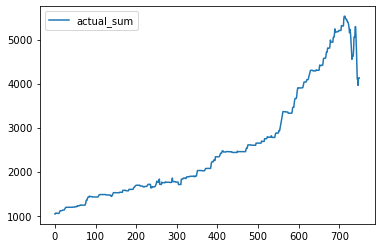

In [16]:
sum_lst = runSimulation(True, False, 1000)
df_compare_acc["actual_sum"] = sum_lst
print(sum_lst[len(sum_lst)-1])
df_compare_acc.plot(y = ["actual_sum"])

2868.718362054936


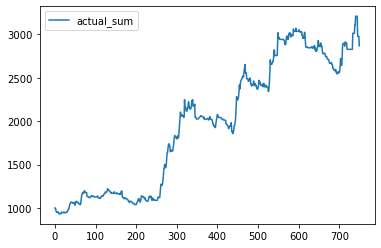

In [17]:
sum_lst = runSimulation(False, True, 1000)
df_compare_acc["actual_sum"] = sum_lst
print(sum_lst[len(sum_lst)-1])
df_compare_acc.plot(y = ["actual_sum"])

11840.478077573684


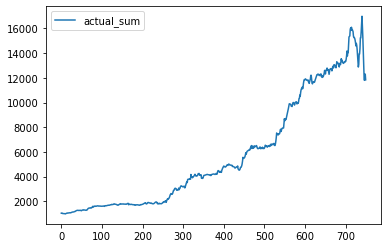

In [18]:
sum_lst = runSimulation(True, True, 1000)
df_compare_acc["actual_sum"] = sum_lst
print(sum_lst[len(sum_lst)-1])
df_compare_acc.plot(y = ["actual_sum"])

In [22]:
for i in tqdm(range(0, vectorized_data.shape[0] - 450, 50)):
    print(i)

100%|██████████| 15/15 [00:00<00:00, 14993.94it/s]0
50
100
150
200
250
300
350
400
450
500
550
600
650
700



In [23]:
round(450*0.89)

400